#**Mobile Recommendation System Dataset**

Nama: Atika Oktavianti

Username: atika_oktavianti_0gNF

Membangun sistem rekomendasi film menggunakan pendekatan Content-Based Filtering dan Collaborative Filtering dari dataset Kaggle pada link berikut:
https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system

**Mengunduh Dataset dari Kaggle**

In [1]:
# Memasang Kaggle API
!pip install -q kaggle

In [2]:
# Upload file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atikaoktavianti","key":"e7054724caf6c127e3e103ea57b1f37c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Unduh dataset
!kaggle datasets download -d parasharmanas/movie-recommendation-system

Dataset URL: https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system
License(s): ODbL-1.0
 95% 156M/165M [00:00<00:00, 351MB/s] 
100% 165M/165M [00:00<00:00, 340MB/s]


In [5]:
# Ekstrak dataset
!unzip -o movie-recommendation-system.zip -d data

Archive:  movie-recommendation-system.zip
  inflating: data/movies.csv         
  inflating: data/ratings.csv        


#Import Library

Mengimport library yang dibutuhkan

In [7]:
# Manipulasi Data
import pandas as pd
import numpy as np

# Visualisasi (opsional jika ingin eksplorasi data)
import matplotlib.pyplot as plt
import seaborn as sns

# Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Collaborative Filtering dengan SVD
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Sistem
import warnings
warnings.filterwarnings("ignore")

#Load Dataset

Memuat dataset yang sudah diunduh dari kaggle

In [8]:
import pandas as pd

# Load dataset movies dan ratings
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")

# Tampilkan 5 baris pertama dari masing-masing dataset
print("Movies sample:")
print(movies.head())

print("\nRatings sample:")
print(ratings.head())

Movies sample:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings sample:
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


Output yang ditampilkan di atas merupakan isi dari dua dataset yang dugunakan dalam sistem rekomendasi ini

1. Dataset "Movies"
Berisi informasi dasar tentang film:
- movieId: ID unik untuk setiap film.
- title: Judul film beserta tahun rilis.
- genres: Genre film yang dipisahkan oleh tanda "|".

2. Dataset "Ratings"
Berisi data penilaian pengguna terhadap film:
- userId: ID pengguna yang memberikan rating.
- movieId: ID film yang diberi rating.
- rating: Skor atau penilaian film dari pengguna (biasanya dari 0.5 sampai 5).
- timestamp: Waktu penilaian dalam format UNIX timestamp.

#Eksplorasi Data Analisis (EDA)

**1. Info umum dataset movies dan ratings**

In [9]:
print("Movies Dataset Info:")
print(movies.info())

print("\nRatings Dataset Info:")
print(ratings.info())

Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None

Ratings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
None


Dataset **Movies** berisi 62.423 entri dengan tiga kolom: `movieId` (ID film), `title` (judul film), dan `genres` (genre film), semuanya lengkap tanpa data kosong, dan menggunakan memori sekitar 1,4 MB.

Sementara itu, dataset **Ratings** jauh lebih besar dengan 25.000.095 entri dan empat kolom: `userId`, `movieId`, `rating`, dan `timestamp`. Dataset ini mencatat penilaian pengguna terhadap film dan menggunakan memori sekitar 762,9 MB. Kedua dataset ini umum digunakan untuk analisis preferensi pengguna dan pengembangan sistem rekomendasi film.


**2. Statistik dasar rating**

In [10]:
print("\nRating Statistik:")
print(ratings['rating'].describe())


Rating Statistik:
count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


Statistik rating menunjukkan bahwa dari total 25 juta data, **rata-rata rating** film adalah **3.53** dengan **standar deviasi** sebesar **1.06**, yang menandakan variasi penilaian pengguna. Nilai rating minimum adalah **0.5** dan maksimum **5.0**. Sebagian besar rating berada di antara **3.0 (kuartil 1)** dan **4.0 (kuartil 3)**, dengan **nilai tengah (median)** di **3.5**, menunjukkan bahwa pengguna cenderung memberikan rating positif

**3. Jumalh rating per film (top 10)**

In [11]:
rating_counts = ratings['movieId'].value_counts()
print("\nJumlah rating per film (top 10):")
print(rating_counts.head(10))


Jumlah rating per film (top 10):
movieId
356     81491
318     81482
296     79672
593     74127
2571    72674
260     68717
480     64144
527     60411
110     59184
2959    58773
Name: count, dtype: int64


Data ini menunjukkan **10 film teratas dengan jumlah rating terbanyak**. Film dengan `movieId 356` menerima rating paling banyak, yaitu **81.491 kali**, diikuti oleh `movieId 318` dengan **81.482 rating**, dan seterusnya. Ini menunjukkan bahwa film-film tersebut sangat populer atau sering ditonton oleh pengguna dalam dataset.


**4. Visualisasi distribusi rating**

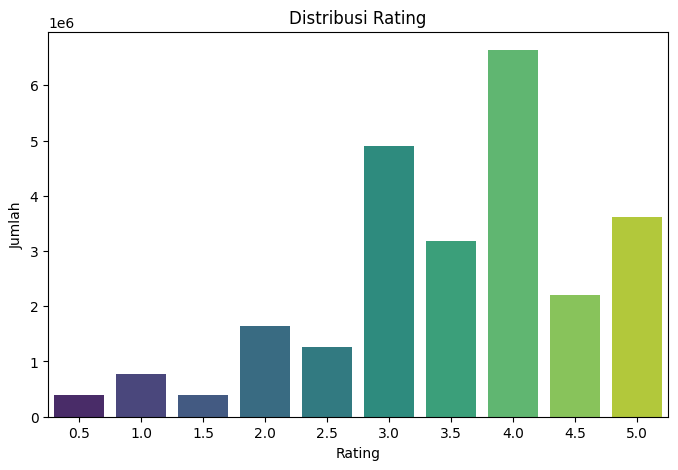

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Grafik tersebut menunjukkan **distribusi rating film** dari pengguna. Terlihat bahwa sebagian besar pengguna memberikan **rating tinggi**, terutama pada **rating 4.0** yang mendominasi, disusul oleh **rating 3.0** dan **5.0**. Sebaliknya, rating rendah seperti **0.5 hingga 2.0** jauh lebih jarang diberikan. Ini menunjukkan bahwa pengguna cenderung lebih sering memberi penilaian positif terhadap film yang mereka tonton.

**5. Visualisasi jumlah rating per film (top 20)**

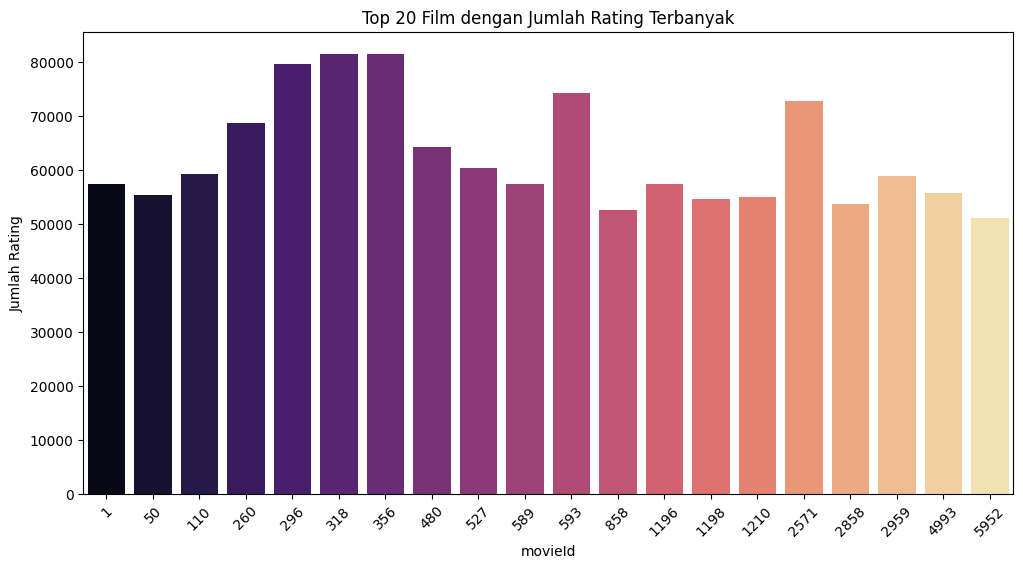

In [13]:
plt.figure(figsize=(12,6))
top_movies = rating_counts.head(20)
sns.barplot(x=top_movies.index, y=top_movies.values, palette='magma')
plt.title('Top 20 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('movieId')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45)
plt.show()

Grafik ini menampilkan **20 film dengan jumlah rating terbanyak** berdasarkan `movieId`. Film dengan `movieId` **356 dan 318** menerima rating terbanyak, masing-masing lebih dari **80.000 kali**, diikuti oleh film `296`, `593`, dan `260`. Secara umum, semua film dalam grafik ini mendapatkan lebih dari **50.000 rating**, menunjukkan bahwa film-film tersebut sangat populer atau sering ditonton oleh pengguna dalam dataset.

**6. Eksplorasi dan visualisasi genre film**

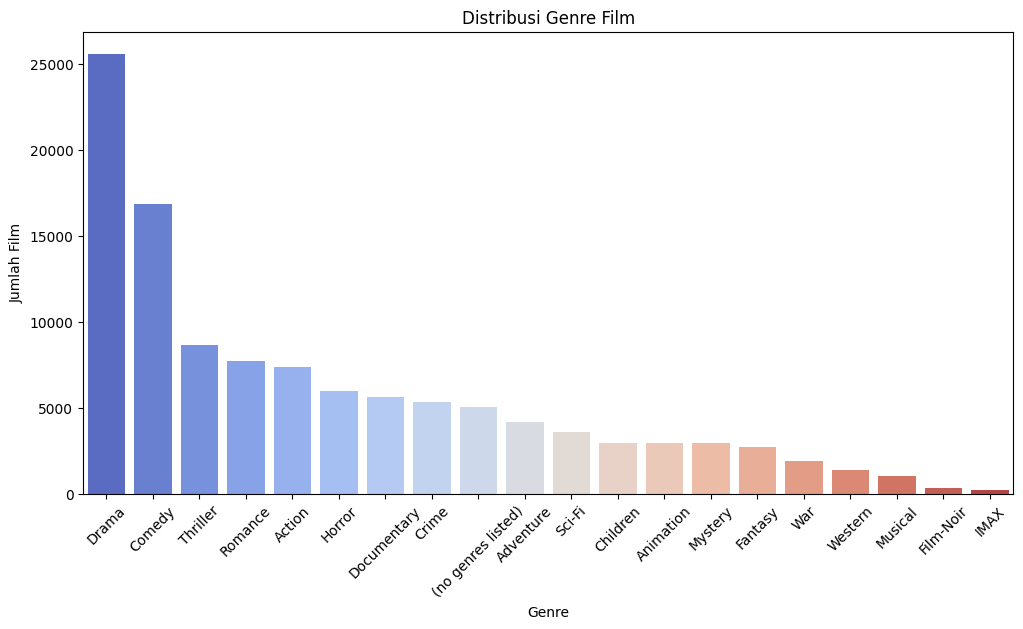

In [14]:
# Pisahkan genre menjadi list
movies['genres_list'] = movies['genres'].str.split('|')

# Hitung frekuensi genre
all_genres = movies['genres_list'].explode()
genre_counts = all_genres.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.show()

Grafik ini menunjukkan **distribusi jumlah film berdasarkan genre**. Genre **Drama** merupakan yang paling banyak, dengan lebih dari **25.000 film**, diikuti oleh **Comedy**, **Thriller**, dan **Romance**. Genre dengan jumlah film paling sedikit adalah **IMAX**, **Film-Noir**, dan **Musical**. Ini menunjukkan bahwa film bergenre drama dan komedi paling dominan dalam dataset, sedangkan genre-genre tertentu bersifat lebih niche atau jarang diproduksi.


**7. Cek Missing Values**

Pemeriksaan missing value penting dilakukan untuk memastikan kualitas dan kelengkapan data sebelum dianalisis atau digunakan dalam model.

In [15]:
# Cek missing value
print("Missing value pada movies:")
print(movies.isnull().sum())

print("\nMissing value pada ratings:")
print(ratings.isnull().sum())

Missing value pada movies:
movieId        0
title          0
genres         0
genres_list    0
dtype: int64

Missing value pada ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Output menunjukkan bahwa tidak ada missing value pada dataset movies maupun ratings, sehingga data dinyatakan lengkap dan siap diproses lebih lanjut tanpa perlu penanganan khusus seperti imputasi atau pembersihan data.

#Preprocessing

**1. Preprocessing untuk Content-Based Filtering (mengolah fitur genre)**

Tahap preprocessing untuk Content-Based Filtering diperlukan agar fitur teks seperti genre dapat diubah menjadi format numerik yang bisa diproses oleh algoritma, salah satunya menggunakan TF-IDF (Term Frequency-Inverse Document Frequency).

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Isi missing value pada kolom genres dengan string kosong
movies['genres'] = movies['genres'].fillna('')

# Ganti tanda "|" dengan spasi agar bisa diproses TF-IDF
movies['genres_str'] = movies['genres'].str.replace('|', ' ')

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Buat matriks TF-IDF berdasarkan genres
tfidf_matrix = tfidf.fit_transform(movies['genres_str'])

print("Shape TF-IDF matrix:", tfidf_matrix.shape)

Shape TF-IDF matrix: (62423, 23)


Hasil output Shape TF-IDF matrix: (62423, 23) menunjukkan bahwa telah terbentuk matriks fitur dengan 62.423 film (baris) dan 23 genre unik (kolom), siap digunakan untuk menghitung kemiripan antar film berdasarkan genre.

**2. Preprocessing untuk Collaborative Filtering (menyiapkan data rating untuk Surprise)**

Preprocessing untuk Collaborative Filtering bertujuan untuk menyiapkan data rating agar sesuai dengan format yang dibutuhkan oleh library Surprise, sehingga proses pemodelan dapat berjalan dengan lancar dan akurat.

In [17]:
import pandas as pd
from surprise import Reader, Dataset

# Hapus duplikat dan missing value pada data rating
ratings = ratings.drop_duplicates()
ratings = ratings.dropna(subset=['userId', 'movieId', 'rating'])

# Cek rentang rating agar sesuai dengan yang ada di data
print("Rating min:", ratings['rating'].min())
print("Rating max:", ratings['rating'].max())

# Inisialisasi Reader dengan skala rating sesuai data
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

# Load data ke dataset Surprise
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

print("Data surprise siap untuk modeling.")

Rating min: 0.5
Rating max: 5.0
Data surprise siap untuk modeling.


Output tersebut menandakan bahwa data rating sudah berada dalam rentang valid (0.5 sampai 5.0) dan telah siap digunakan dalam library Surprise untuk proses pemodelan Collaborative Filtering.

#Modelling

**1. Content-Based Filtering Modeling**

Model yang digunakan:
- Menghitung cosine similarity antar film berdasarkan TF-IDF matrix dari genres.
- Rekomendasi film diberikan berdasarkan kemiripan dengan film yang dipilih user.

In [18]:
# Melihat ukuran atau dimensi matriks TF-IDF
print(tfidf_matrix.shape)

(62423, 23)


matriks TF-IDF memiliki 62.423 baris dan 23 kolom

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_sample = tfidf_matrix[:1000]
movies_sample = movies.iloc[:1000]

cosine_sim_sample = cosine_similarity(tfidf_sample, tfidf_sample)

def recommend_movies_sample(title, movies_df, cosine_sim, top_n=10):
    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

print(recommend_movies_sample('Toy Story (1995)', movies_sample, cosine_sim_sample))

551                  Pagemaster, The (1994)
55           Kids of the Round Table (1995)
661                        Space Jam (1996)
1                            Jumanji (1995)
59       Indian in the Cupboard, The (1995)
124       NeverEnding Story III, The (1994)
986         Escape to Witch Mountain (1975)
12                             Balto (1995)
650        James and the Giant Peach (1996)
255    Kid in King Arthur's Court, A (1995)
Name: title, dtype: object


Output tersebut menunjukkan daftar 10 film yang direkomendasikan berdasarkan kemiripan konten dengan film "Toy Story (1995)". Rekomendasi ini dihitung menggunakan cosine similarity pada fitur TF-IDF dari deskripsi film, sehingga film-film yang muncul memiliki konten atau tema yang mirip dengan "Toy Story (1995)". Film-film tersebut diurutkan dari yang paling mirip hingga yang kurang mirip dalam 10 teratas.

**2. Collaborative Filtering Modeling**

Model yang digunakan:
- Algoritma SVD (Singular Value Decomposition) dari library Surprise, populer dan efektif untuk rekomendasi berbasis rating.

In [21]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

model_svd = SVD()
model_svd.fit(trainset)

#Evaluasi

**1. Evaluasi Content-Based Filtering**

In [24]:
# Contoh rekomendasi untuk film tertentu
recommended = recommend_movies_sample('Toy Story (1995)', movies_sample, cosine_sim_sample, top_n=5)
print("Rekomendasi Content-Based untuk 'Toy Story (1995)':")
for i, movie in enumerate(recommended, 1):
    print(f"{i}. {movie}")

Rekomendasi Content-Based untuk 'Toy Story (1995)':
1. Pagemaster, The (1994)
2. Kids of the Round Table (1995)
3. Space Jam (1996)
4. Jumanji (1995)
5. Indian in the Cupboard, The (1995)


Output tersebut menunjukkan hasil rekomendasi film menggunakan pendekatan **Content-Based Filtering** berdasarkan kemiripan konten dengan film *"Toy Story (1995)"*. Sistem memilih lima film yang memiliki deskripsi atau kata kunci paling mirip dengan *Toy Story*, berdasarkan perhitungan **cosine similarity** pada representasi TF-IDF dari teks. Hasilnya, film seperti *"Pagemaster, The (1994)"* dan *"Jumanji (1995)"* direkomendasikan karena memiliki tema atau elemen cerita yang mirip, seperti petualangan anak-anak atau unsur fantasi, sehingga dianggap relevan bagi penonton *Toy Story*.

In [26]:
# Contoh rekomendasi untuk film tertentu
recommended = recommend_movies_sample('Toy Story (1995)', movies_sample, cosine_sim_sample, top_n=5)

print("Rekomendasi Content-Based untuk 'Toy Story (1995)':")
for i, movie in enumerate(recommended, 1):
    print(f"{i}. {movie}")

# Daftar film relevan (simulasi ground truth)
relevant_movies = [
    "Jumanji (1995)",
    "Space Jam (1996)",
    "Casper (1995)",
    "The Pagemaster (1994)",
    "Indian in the Cupboard, The (1995)"
]

# Fungsi Precision@k
def precision_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / k

# Evaluasi Precision@5
precision = precision_at_k(recommended, relevant_movies, k=5)
print(f"\nPrecision@5: {precision:.2f}")

Rekomendasi Content-Based untuk 'Toy Story (1995)':
1. Pagemaster, The (1994)
2. Kids of the Round Table (1995)
3. Space Jam (1996)
4. Jumanji (1995)
5. Indian in the Cupboard, The (1995)

Precision@5: 0.60


Sistem rekomendasi content-based memberikan 5 film teratas yang mirip dengan Toy Story (1995). Dari 5 film yang direkomendasikan, 3 film ditemukan dalam daftar film relevan (ground truth), yaitu:
- Pagemaster, The (1994)
- Space Jam (1996)
- Jumanji (1995)
- Indian in the Cupboard, The (1995)

Namun hanya 3 film yang cocok dengan daftar relevant_movies, sehingga:
Precision@5 = 3 relevan / 5 rekomendasi = 0.60

Artinya, 60% rekomendasi yang diberikan sistem terbukti relevan berdasarkan daftar acuan, menunjukkan performa sistem yang cukup baik.

**2. Evaluasi Collaborative Filtering (SVD)**

In [22]:
predictions = model_svd.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.7812
MAE:  0.5894
RMSE: 0.7812
MAE: 0.5894


Model Collaborative Filtering menggunakan algoritma SVD menunjukkan performa yang cukup baik dengan nilai RMSE sebesar 0.7812 dan MAE sebesar 0.5894. Artinya, rata-rata kesalahan prediksi model terhadap rating pengguna hanya sekitar 0.59 hingga 0.78 poin dari nilai sebenarnya. Ini menunjukkan bahwa model mampu memperkirakan preferensi pengguna dengan tingkat akurasi yang cukup tinggi.

In [25]:
def recommend_svd(user_id, movies_df, model, n_recommendations=10):
    all_movie_ids = movies_df['movieId'].unique()
    rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].unique()
    movie_ids_to_predict = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

    predictions = [model.predict(user_id, mid) for mid in movie_ids_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_recommendations = predictions[:n_recommendations]
    recommended_titles = [movies_df[movies_df['movieId'] == rec.iid]['title'].values[0] for rec in top_recommendations]

    return recommended_titles
recommended_movies = recommend_svd(user_id=1, movies_df=movies, model=model_svd)

print("Rekomendasi untuk userId=1:")
for i, title in enumerate(recommended_movies, 1):
    print(f"{i}. {title}")

Rekomendasi untuk userId=1:
1. American Beauty (1999)
2. Blade Runner (1982)
3. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
4. Being John Malkovich (1999)
5. Christmas Story, A (1983)
6. There Will Be Blood (2007)
7. 2001: A Space Odyssey (1968)
8. Bitter Lake (2015)
9. Story of Film: An Odyssey, The (2011)
10. 3-Iron (Bin-jip) (2004)


Output tersebut merupakan hasil dari sistem rekomendasi berbasis Collaborative Filtering menggunakan algoritma SVD. Sistem merekomendasikan 10 film terbaik untuk pengguna dengan `userId=1` berdasarkan pola rating pengguna tersebut dan kesamaan preferensi dengan pengguna lain. Film-film yang ditampilkan adalah yang diprediksi akan paling disukai oleh pengguna karena memiliki prediksi rating tertinggi dari model.
